In [282]:
#import relevant libraries
import datetime, warnings, scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import math
 #can create own custom layers in keras 
from keras.layers import Dense #standard neaaural network 
from keras.layers import LSTM #long short term memory layer, since looking at most likely sequential data 

from sklearn.preprocessing import MinMaxScaler, StandardScaler #for pre editing data 
from sklearn.metrics import mean_squared_error #to compute errors 

import warnings
warnings.filterwarnings('ignore')

In [283]:
df = pd.read_csv("air_quality.csv", sep = " ") #seperate by space because of format in excel 

In [284]:
df.head(5)

,No,Profile,Tanggal,Jam,O3,CO,NO2,SO2,NO,CO2,...,PM4,PM10,TSP,TEMP,HUM,WS,WD,ISPU,Status,Unnamed: 22
0,1,BANDUNG,2019-05-19,00:04:19,21.35,0.78,6.77,14.06,26.168,409.86,...,0.0,2.77,0.0,21.4,100.0,0.600,5,9,BAIK,NaN
1,2,BANDUNG,2019-05-19,00:15:01,5.93,0.82,14.87,17.23,53.853,394.79,...,0.0,11.95,0.0,42.6,200.0,0.000,2,12,BAIK,NaN
2,3,BANDUNG,2019-05-19,00:30:06,6.62,0.63,22.24,2.31,38.304,390.66,...,0.0,12.71,0.0,63.6,299.2,0.000,2,13,BAIK,NaN
3,4,BANDUNG,2019-05-19,00:49:19,13.29,0.44,19.00,5.32,18.962,401.23,...,0.0,1.20,0.0,21.3,88.2,0.525,5,6,BAIK,NaN
4,5,BANDUNG,2019-05-19,01:04:19,2.44,0.47,26.74,13.61,35.270,381.67,...,0.0,3.52,0.0,21.3,97.4,0.975,5,9,BAIK,NaN


# Convert Time to Datetime Object

In [285]:
def combine_date(df, tab_name):
    list_tab = []
    for i in range(df.shape[0]):
        list_tab.append(df.loc[i, 'Tanggal'] + 'T' + df.loc[i, tab_name][0:2])
    return np.array(list_tab, dtype='datetime64')



In [286]:
df['Datetime'] = combine_date(df, 'Jam')

# Convert into Hourly Data

In [305]:
df=df[['Datetime','O3','CO','NO2','SO2','NO','CO2','VOC','PM1', 'PM2.5', 'PM4', 'PM10', 'TSP', 'TEMP', 'HUM', 'WS', 'WD', 'ISPU']] 

In [306]:
df2 = df.groupby(['Datetime']).mean()
df2

,O3,CO,NO2,SO2,NO,CO2,VOC,PM1,PM2.5,PM4,PM10,TSP,TEMP,HUM,WS,WD,ISPU
Datetime,,,,,,,,,,,,,,,,,
2019-05-19 00:00:00,11.797500,0.667500,15.720000,9.730000,34.321750,399.135000,439.223000,0.0,0.0,0.0,7.157500,0.0,37.225000,171.850000,0.28125,3.500000,10.000000
2019-05-19 01:00:00,3.816667,0.373333,22.600000,20.090000,39.821000,388.536667,250.394000,0.0,0.0,0.0,3.293333,0.0,20.966667,95.033333,0.67500,4.666667,12.666667
2019-05-19 02:00:00,6.450000,0.332500,24.130000,26.310000,51.293250,396.242500,251.045750,0.0,0.0,0.0,6.487500,0.0,20.150000,97.500000,0.09375,3.750000,16.250000
2019-05-19 03:00:00,4.740000,0.180000,25.975000,24.390000,43.518500,401.355000,252.248750,0.0,0.0,0.0,4.700000,0.0,19.850000,100.000000,0.07500,5.000000,15.000000
2019-05-19 04:00:00,19.692500,0.202500,20.395000,18.622500,53.379250,399.335000,694.239750,0.0,0.0,0.0,5.262500,0.0,53.475000,272.500000,0.18750,5.250000,13.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-18 19:00:00,6.428333,0.048333,13.251667,11.058333,56.823833,398.081667,242.439833,0.0,0.0,0.0,4.343333,0.0,23.833333,70.283333,2.08750,4.000000,7.666667
2019-08-18 20:00:00,10.741667,0.078333,9.021667,11.830000,38.051167,402.715000,241.786167,0.0,0.0,0.0,7.805000,0.0,22.783333,77.083333,9.53750,4.500000,10.666667
2019-08-18 21:00:00,8.166667,0.081667,11.540000,16.550000,46.963500,389.273333,229.602500,0.0,0.0,0.0,4.603333,0.0,21.850000,71.383333,30.68750,4.666667,10.500000


# Descriptive Statistics

In [307]:
df2.describe() #descriptive statistics 

,O3,CO,NO2,SO2,NO,CO2,VOC,PM1,PM2.5,PM4,PM10,TSP,TEMP,HUM,WS,WD,ISPU
count,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000
mean,8.538909,0.233172,16.681910,12.013894,37.086256,394.616480,260.053778,0.309564,0.383692,0.451982,6.157770,0.562012,25.266942,77.634191,24.291226,7.129031,10.097848
std,3.997292,0.388102,5.373487,4.411251,12.521778,4.180224,60.773321,2.286104,2.874126,3.378291,4.149511,4.184787,6.707977,29.743129,51.993683,3.523245,5.049788
min,0.270000,0.010000,2.040000,2.162500,3.128750,380.420000,187.518000,0.000000,0.000000,0.000000,0.885000,0.000000,11.250000,26.866667,0.000000,0.000000,4.250000
25%,5.881667,0.083333,13.010000,9.015000,28.443500,391.830000,247.798333,0.000000,0.000000,0.000000,4.340000,0.000000,21.266667,57.850000,0.237500,4.666667,8.166667
50%,7.813333,0.160000,15.916667,11.730000,39.252250,394.602000,250.926250,0.000000,0.000000,0.000000,5.571667,0.000000,24.100000,77.083333,1.312500,5.833333,9.500000
75%,10.373333,0.296667,19.935000,14.595000,46.015500,397.415000,253.286667,0.000000,0.000000,0.000000,7.090000,0.000000,28.400000,94.066667,5.075000,10.500000,11.000000
max,33.741667,13.950000,99.600000,46.290000,194.554000,408.820000,1240.713500,51.600000,68.700000,79.800000,91.600000,92.900000,124.600000,313.400000,199.200000,15.000000,156.500000


# Calculated Quantile for each Value 

In [308]:
def calculated_quantile(i, df):
    Q1 = df2[[i]].quantile(0.25)[0]
    Q3 = df2[[i]].quantile(0.75)[0]
    IQR = Q3 - Q1
    min = df[[i]].min()[0]
    max = df[[i]].max()[0]
    max_IQR = Q1 - 1.5 * IQR
    min_IQR = Q3 + 1.5 * IQR 
    
    return Q1, Q3, min, max, min_IQR, max_IQR

#delete first and last rows to avoid missing data value extraplotation usually have a lot of nulll values 
df2.drop(index = [df2.index[0], df2.index[df2.shape[0]-1]], inplace= True)

# Outliers

In [309]:
#find and interpolate data
for i in df2.columns:
    print('\nAttribute-', i, ':')
    Q1, Q3, min, max, min_IQR, max_IQR = calculated_quantile(i, df2)
    
    print('Q1 = %.2f' % Q1)
    print('Q3 = %.2f' % Q3)
    
    print('min_IQR = %.2f' % min_IQR)
    print('max_IQR = % .2f' % max_IQR)
    
    if (min < min_IQR):
        print('--->low outlier is found =%.2f'% min)
    if (max > max_IQR):
        print('---->high outlier is found =%.2f'% max)

def convert_nan(x, max_IQR=max_IQR, min_IQR=min_IQR):
    if((x > max_IQR) | (x < min_IQR)):
        x = np.nan
    else:
        x = x
    return x

#values below should match descriptive statistics computed above 


Attribute- O3 :
Q1 = 5.88
Q3 = 10.37
min_IQR = 17.10
max_IQR = -0.85
--->low outlier is found =0.27
---->high outlier is found =33.74

Attribute- CO :
Q1 = 0.08
Q3 = 0.30
min_IQR = 0.62
max_IQR = -0.24
--->low outlier is found =0.01
---->high outlier is found =13.95

Attribute- NO2 :
Q1 = 13.01
Q3 = 19.93
min_IQR = 30.32
max_IQR =  2.62
--->low outlier is found =2.04
---->high outlier is found =99.60

Attribute- SO2 :
Q1 = 9.00
Q3 = 14.61
min_IQR = 23.01
max_IQR =  0.60
--->low outlier is found =2.16
---->high outlier is found =46.29

Attribute- NO :
Q1 = 28.44
Q3 = 46.02
min_IQR = 72.37
max_IQR =  2.09
--->low outlier is found =3.13
---->high outlier is found =194.55

Attribute- CO2 :
Q1 = 391.83
Q3 = 397.41
min_IQR = 405.77
max_IQR =  383.47
--->low outlier is found =380.42
---->high outlier is found =408.82

Attribute- VOC :
Q1 = 247.80
Q3 = 253.29
min_IQR = 261.52
max_IQR =  239.57
--->low outlier is found =187.52
---->high outlier is found =1240.71

Attribute- PM1 :
Q1 = 0.00
Q3 

In [310]:
def convert_nan_HUM(x, max_IQR=100.0, min_IQR=min_IQR):
    if ((x > max_IQR) | (x < min_IQR)): #if both (and)
        x = np.nan #NULL 
    else:
        x = x
    return x

#humidity has outliers-> in an effort to fix 

    if( i == 'HUM'): #column specific to humudity 
        df2[i] = df2[i].map(convert_nan_HUM)
        df2[i] = interpolate(method='linear')
    if (i != 'HUM'):
        df2[i] = df2[i].map(convert_nan_HUM)
        df2[i] = df2[i].interpolate(method='linear') #fills in based on linear regression model of simliar data 
    if len(df2[df2[i].isnull()][i] == 0):
        print("##### outliers have been interpolated")

# Log Tranformation to deal with Skewed Data

In [311]:
dataset = np.log1p(df2[['TEMP']].values) #domain specific 
dataset.shape
df.columns

Index(['Datetime', 'O3', 'CO', 'NO2', 'SO2', 'NO', 'CO2', 'VOC', 'PM1',
       'PM2.5', 'PM4', 'PM10', 'TSP', 'TEMP', 'HUM', 'WS', 'WD', 'ISPU'],
      dtype='object')

In [312]:
#create new df to compare original to log transformation
dist_df = pd.DataFrame({'TEMP':df2['TEMP'].values, 
                       'log_temp': dataset[:, 0]})

<Figure size 864x360 with 0 Axes>

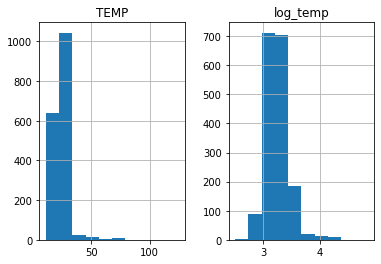

In [313]:
#create new histogram to plot original vs log transformation
plt.figure(figsize = (12,5))
dist_df.hist(); #integrates histogram right back into pandas

# Split the Data into Train & Test Data

In [314]:
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size #training size - length of the dataset 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

1301 434


## Convert an Array of Values into a Dataset Matrix

In [315]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0] #looking foward to next piece of data , train with yesterdays data 
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


In [316]:
#reshape the train and test data
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(train,look_back)

In [317]:
#print each value of trian and test shape 
print('TrainX shape:', trainX.shape)
print('TrainY shape:', trainY.shape)
print('TestX shape:', testX.shape)
print('TestY shape:', testY.shape)

TrainX shape: (1299, 1)
TrainY shape: (1299,)
TestX shape: (1299, 1)
TestY shape: (1299,)


In [318]:
def convert_nan_HUM(x, max_IQR=100.0, min_IQR=min_IQR):
    if ((x > max_IQR) | (x < min_IQR)): #if both (and)
        x = np.nan #NULL 
    else:
        x = x
    return x

#humidity has outliers-> in an effort to fix 

    if( i == 'HUM'): #column specific to humudity 
        df2[i] = df2[i].map(convert_nan_HUM)
        df2[i] = interpolate(method='linear')
    if (i != 'HUM'):
        df2[i] = df2[i].map(convert_nan_HUM)
        df2[i] = df2[i].interpolate(method='linear') #fills in based on linear regression model of simliar data 
    if len(df2[df2[i].isnull()][i] == 0):
        print("##### outliers have been interpolated")

# Add another dimension

In [319]:
#reshape the input array in the form [samples, time stamps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('shape of trainX : ', trainX.shape)
print('shape of testX : ', testX.shape)

shape of trainX :  (1299, 1, 1)
shape of testX :  (1299, 1, 1)


# Create and Fit the LSTM Neaural Network

In [ ]:
model = tf.keras.Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) #long-short term memory(text), http://kerias.io/API/layers 
model.add(Dense(1)) #dense model is basic foward or reverse propogagation to program the model 

model.compile(loss = 'mean_squared_error', optimizer = 'Adam') #brings everything together
model.fit(trainX, trainY, epochs = 500, batch_size = 32, verbose = 2) #500 epochs probably a lot for this, 200 or 300 best

Epoch 1/500
41/41 - 1s - loss: 9.9913
Epoch 2/500
41/41 - 0s - loss: 9.1481
Epoch 3/500
41/41 - 0s - loss: 8.1739
Epoch 4/500
41/41 - 0s - loss: 7.1211
Epoch 5/500
41/41 - 0s - loss: 6.0616
Epoch 6/500
41/41 - 0s - loss: 5.0534
Epoch 7/500
41/41 - 0s - loss: 4.1370
Epoch 8/500
41/41 - 0s - loss: 3.3360
Epoch 9/500
41/41 - 0s - loss: 2.6567
Epoch 10/500
41/41 - 0s - loss: 2.0948
Epoch 11/500
41/41 - 0s - loss: 1.6372
Epoch 12/500
41/41 - 0s - loss: 1.2681
Epoch 13/500
41/41 - 0s - loss: 0.9714
Epoch 14/500
41/41 - 0s - loss: 0.7306
Epoch 15/500
41/41 - 0s - loss: 0.5325
Epoch 16/500
41/41 - 0s - loss: 0.3664
Epoch 17/500
41/41 - 0s - loss: 0.2309
Epoch 18/500
41/41 - 0s - loss: 0.1330
Epoch 19/500
41/41 - 0s - loss: 0.0753
Epoch 20/500
41/41 - 0s - loss: 0.0492
Epoch 21/500
41/41 - 0s - loss: 0.0397
Epoch 22/500
41/41 - 0s - loss: 0.0368
Epoch 23/500
41/41 - 0s - loss: 0.0360
Epoch 24/500
41/41 - 0s - loss: 0.0359
Epoch 25/500
41/41 - 0s - loss: 0.0358
Epoch 26/500
41/41 - 0s - loss: 0.

Epoch 209/500
41/41 - 0s - loss: 0.0324
Epoch 210/500
41/41 - 0s - loss: 0.0323
Epoch 211/500
41/41 - 0s - loss: 0.0323
Epoch 212/500
41/41 - 0s - loss: 0.0323
Epoch 213/500
41/41 - 0s - loss: 0.0328
Epoch 214/500
41/41 - 0s - loss: 0.0324
Epoch 215/500
41/41 - 0s - loss: 0.0323
Epoch 216/500
41/41 - 0s - loss: 0.0324
Epoch 217/500
41/41 - 0s - loss: 0.0323
Epoch 218/500
41/41 - 0s - loss: 0.0324
Epoch 219/500
41/41 - 0s - loss: 0.0326
Epoch 220/500
41/41 - 0s - loss: 0.0328
Epoch 221/500
41/41 - 0s - loss: 0.0323
Epoch 222/500
41/41 - 0s - loss: 0.0323
Epoch 223/500
41/41 - 0s - loss: 0.0324
Epoch 224/500
41/41 - 0s - loss: 0.0323
Epoch 225/500
41/41 - 0s - loss: 0.0323
Epoch 226/500
41/41 - 0s - loss: 0.0326
Epoch 227/500
41/41 - 0s - loss: 0.0324
Epoch 228/500
41/41 - 0s - loss: 0.0323
Epoch 229/500
41/41 - 0s - loss: 0.0323
Epoch 230/500
41/41 - 0s - loss: 0.0324
Epoch 231/500
41/41 - 0s - loss: 0.0323
Epoch 232/500
41/41 - 0s - loss: 0.0323
Epoch 233/500
41/41 - 0s - loss: 0.0325


In [ ]:
#make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

#invert predictions
trainPredict = np.expm1(trainPredict)
trainY = np.expm1(trainY)
testPredict = np.expm1(testPredict)
testY = np.expm1(testY)

#calculate root square mean error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(trainY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))